In [161]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim

# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 1000

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True)

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


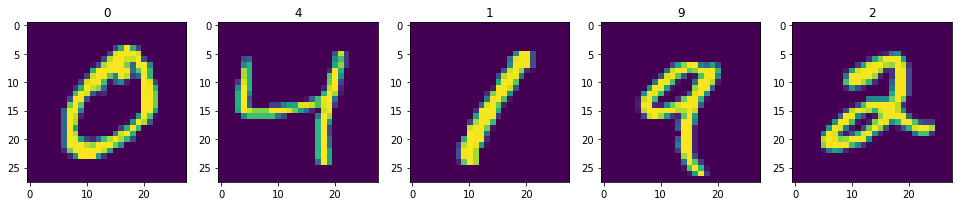

In [96]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [164]:
# Number of times to rerun the training dataset
epochs = 3

# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 1000

# Step size for gradiant decent
learning_rate = 0.01

# Gives the network a chance to jump out of a local minima
momentum = 0.5

# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = False

model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [120]:
def plot_learning_rate(batch_accuracies):
    fig, ax = plt.subplots()
    ax.plot(
        range(0, len(batch_accuracies)), 
        batch_accuracies
    )

    ax.set_ylim((0, 1))
    ax.set(
        xlabel='training batches', 
        ylabel='accuracy',
        title='Model accuracy during training'
    )

    plt.show()

In [162]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [122]:
def train_model(model):

    total = 0
    nr_correct = 0

    accuracy = []
    train_loss = list()
    for epoch in range(epochs):

        model.train()
        # training
        for itr, (image, label) in enumerate(train_dataloader):

            pred = model(image)
            
            optimizer.zero_grad()

            loss = criterion(pred, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            
            _, predictions = torch.max(pred, 1)
            total = image.size(0)
            nr_correct = torch.sum(predictions == label).item()
            accuracy.append(nr_correct / total)
            
    return accuracy

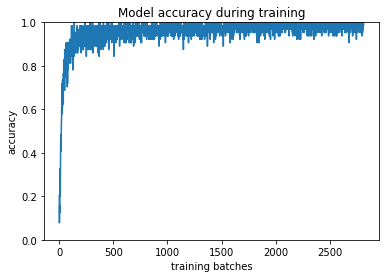

In [166]:
from model import Model
model = Model()
accuracy = train_model(model)
plot_learning_rate(accuracy)

In [165]:
 # validation

model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

val_loss = list()

total_train_loss = 0
total_val_loss = 0

model.eval()
total = 0

accuracy = []

for itr, (image, label) in enumerate(val_dataloader):

    pred = model(image)

    loss = criterion(pred, label)
    total_val_loss += loss.item()

    pred = torch.nn.functional.softmax(pred, dim=1)
    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1

accuracy = total / len(mnist_valset)

print(accuracy)

0.09722222222222222


In [131]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / (itr + 1)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 31.30031949


In [134]:
# visualize results
fig=plt.figure(figsize=(20, 10))
for i in range(1, 11):
    img = transforms.ToPILImage(mode='L')(results[i][0].squeeze(0).detach().cpu())
    fig.add_subplot(2, 5, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
plt.show()

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

<Figure size 1440x720 with 0 Axes>